In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = scipy.io.loadmat('dataset/train_32x32.mat')

In [82]:
train

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Dec  5 21:09:26 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[[[ 33,  84,  19, ...,  92, 190, 216],
          [ 30,  76,  54, ...,  78, 188, 217],
          [ 38,  59, 110, ..., 101, 191, 212]],
 
         [[ 15,  86,  20, ...,  94, 205, 221],
          [ 23,  73,  52, ...,  82, 203, 222],
          [ 19,  66, 111, ..., 105, 206, 217]],
 
         [[ 15,  77,  25, ..., 114, 220, 226],
          [ 17,  78,  57, ..., 101, 218, 227],
          [ 19,  56, 116, ..., 125, 220, 221]],
 
         ...,
 
         [[ 72,  90,  65, ..., 200, 229, 200],
          [ 65,  78, 144, ..., 201, 231, 199],
          [ 56,  69, 223, ..., 203, 224, 191]],
 
         [[ 82,  88,  78, ..., 192, 229, 193],
          [ 77,  77, 148, ..., 193, 229, 188],
          [ 57,  67, 218, ..., 195, 224, 182]],
 
         [[ 89,  88,  98, ..., 190, 229, 197],
          [ 79,  78, 158, ..., 191, 228, 189],
          [ 59,  66, 220, 

In [ ]:
X_train = train['X']  
y_train = train['y']  

print(X_train.shape)
print(y_train.shape)

In [85]:
y_train[:10]

array([[1],
       [9],
       [2],
       [3],
       [2],
       [5],
       [9],
       [3],
       [3],
       [1]], dtype=uint8)

In [86]:
X_train = np.transpose(X_train, (3, 0, 1, 2))  # transpose axes into (73257, 32, 32, 3)

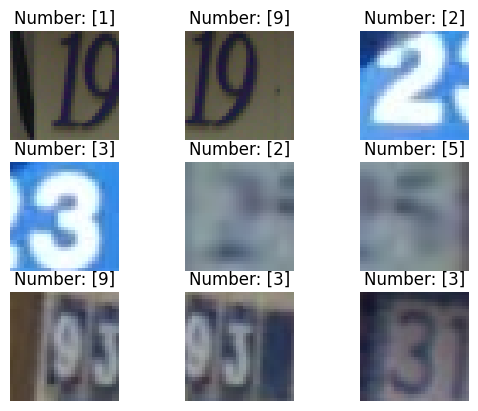

In [87]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i])
    plt.title(f"Number: {y_train[i]}")
    plt.axis('off')  

In [88]:
y_train = y_train.flatten()

In [89]:
unique_classes, counts = np.unique(y_train, return_counts=True)

In [90]:
sample_counts_train = dict(zip(unique_classes, counts))
sample_counts_train

{1: 13861,
 2: 10585,
 3: 8497,
 4: 7458,
 5: 6882,
 6: 5727,
 7: 5595,
 8: 5045,
 9: 4659,
 10: 4948}

<BarContainer object of 10 artists>

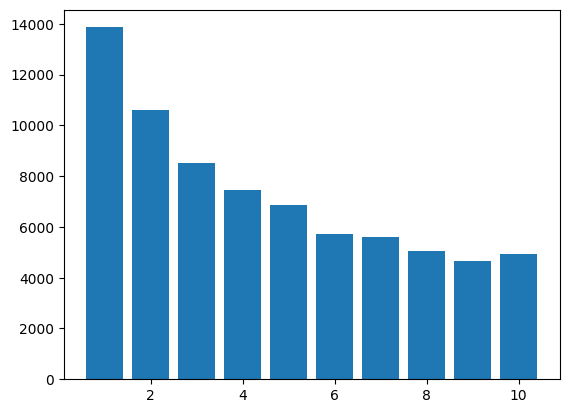

In [91]:
plt.bar(unique_classes, counts)

In [92]:
#expand each class to 7000 samples
extra = scipy.io.loadmat('dataset/extra_32x32.mat')

In [93]:
X_extra = extra['X']  
y_extra = extra['y'] 

In [94]:
print(X_extra.shape)
print(y_extra.shape)

(32, 32, 3, 531131)
(531131, 1)


In [95]:
X_extra = np.transpose(X_extra, (3, 0, 1, 2))  # transpose axes into (73257, 32, 32, 3)

In [96]:
y_extra = y_extra.flatten()
unique_classes, counts_extra = np.unique(y_extra, return_counts=True)
sample_counts_extra = dict(zip(unique_classes, counts_extra))

In [97]:
sample_counts_extra

{1: 90560,
 2: 74740,
 3: 60765,
 4: 50633,
 5: 53490,
 6: 41582,
 7: 43997,
 8: 35358,
 9: 34456,
 10: 45550}

<BarContainer object of 10 artists>

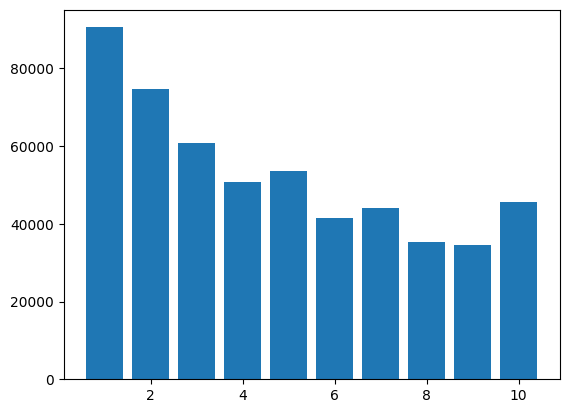

In [98]:
plt.bar(unique_classes_extra, counts_extra)

In [99]:
target_samples_number = 7000

In [115]:
X_train_balanced = []
y_train_balanced = []

for class_label in unique_classes:
    num_missing = target_samples_number - sample_counts_train[class_label]

    extra_indices = np.where(y_extra == class_label)[0]
    
    X_class = X_train[y_train == class_label]
    y_class = y_train[y_train == class_label]

    if num_missing > 0:
        X_class = np.concatenate((X_class, X_extra[extra_indices[:num_missing]]), axis=0)
        y_class = np.concatenate((y_class, y_extra[extra_indices[:num_missing]]), axis=0)

    # If size> 7000 randomly select 7000 samples
    if len(y_class) > target_samples_number:
        indices = np.random.choice(len(y_class), target_samples_number, replace=False)
        X_class = X_class[indices]
        y_class = y_class[indices]

    X_train_balanced.append(X_class)
    y_train_balanced.append(y_class)


X_train_balanced = np.concatenate(X_train_balanced, axis=0)
y_train_balanced = np.concatenate(y_train_balanced, axis=0)


In [117]:
unique_classes, counts_balanced= np.unique(y_train_balanced, return_counts=True)
dict(zip(unique_classes, counts_balanced))

{1: 7000,
 2: 7000,
 3: 7000,
 4: 7000,
 5: 7000,
 6: 7000,
 7: 7000,
 8: 7000,
 9: 7000,
 10: 7000}

In [118]:
import torchvision.transforms as transforms

In [128]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5], std=[0.5])  
])

In [129]:
transform_augmented = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1)
    transforms.RandomRotation(10),  
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), 
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [121]:
test = scipy.io.loadmat('dataset/test_32x32.mat')

In [124]:
X_test = test['X']  
y_test = test['y'] 

print(X_test.shape)
print(y_test.shape)

(32, 32, 3, 26032)
(26032, 1)


In [125]:
X_test = np.transpose(X_test, (3, 0, 1, 2))  # transpose axes into (73257, 32, 32, 3)

y_test = y_test.flatten()

unique_classes, counts_test = np.unique(y_test, return_counts=True)
dict(zip(unique_classes, counts_test))

{1: 5099,
 2: 4149,
 3: 2882,
 4: 2523,
 5: 2384,
 6: 1977,
 7: 2019,
 8: 1660,
 9: 1595,
 10: 1744}

In [126]:
print(X_test.shape)
print(y_test.shape)

(26032, 32, 32, 3)
(26032,)


In [127]:
import torch

In [130]:
def apply_transform(X, y, transform):
    X_transformed = torch.stack([transform(img) for img in X])  
    y_transformed = torch.tensor(y, dtype=torch.long)  
    return X_transformed, y_transformed


In [133]:
X_train_transformed, y_train_transformed = apply_transform(X_train_balanced, y_train_balanced, transform_augmented)
X_test_transformed, y_test_transformed = apply_transform(X_test, y_test, transform)

torch.Size([70000, 1, 32, 32])
torch.Size([70000])


In [134]:
print(X_train_transformed.shape) 
print(y_train_transformed.shape)  

torch.Size([70000, 1, 32, 32])
torch.Size([70000])
